In [1]:
import pandas as pd
from datetime import datetime

In [2]:
csv_path_launch_ts = "job_launch_ts.csv"
df_launch = pd.read_csv(csv_path_launch_ts).fillna("")
# deduplication by run_name, take the first one
print(df_launch.shape)
df_launch = df_launch.sort_values(by='run_name', ascending=False).drop_duplicates(subset='run_name', keep='first')
print(df_launch.shape)
df_launch.sample(2)

(258, 2)
(140, 2)


,run_name,launch_time
92,time-to-train_1b-llama-tok-v4-256-8b217493-0714,2024-07-14 01:41:13 PM PDT
246,time-to-train_1b-llama-tok-v4-256-f7225be5-0717,2024-07-17 07:59:46 AM PDT


In [3]:
csv_path_jobs = "wandb_runs_time-to-train.csv"
df_jobs = pd.read_csv(csv_path_jobs)
print(df_jobs.shape)
# rename total_time to total_job_time
df_jobs = df_jobs.rename(columns={"total_time": "total_job_time"})
df_jobs.sample(2)

(71, 13)


,run_name,runtime,total_job_time,training_time,create_time,heartbeat_time,tokenizer,train_batch_size,examples_per_second,global_step,parameters,num_devices,mfu
68,time-to-train_1b-llama-tok-0707,14.335911,14.336389,12.179243,2024-07-09 06:40:05 PDT,2024-07-09 21:00:16 PDT,meta-llama/Llama-2-7b-hf,1024,757.211074,32422,1204881408,256,NaN
37,time-to-train_1b-llama-tok-v5litepod-256-4b0b6...,23.422640,23.468056,19.530556,2024-07-15 21:15:31 PDT,2024-07-16 20:43:36 PDT,meta-llama/Llama-2-7b-hf,1024,757.317236,51999,1204881408,256,NaN


In [4]:
df = pd.merge(df_jobs, df_launch, on="run_name", how="left").fillna("")
print(df.shape)
df.sample(2)

(71, 14)


,run_name,runtime,total_job_time,training_time,create_time,heartbeat_time,tokenizer,train_batch_size,examples_per_second,global_step,parameters,num_devices,mfu,launch_time
19,time-to-train_1b-llama-tok-v4-256-dd608a62-0716,11.342241,11.343611,10.840799,2024-07-16 22:03:42 PDT,2024-07-17 09:24:19 PDT,meta-llama/Llama-2-7b-hf,1024,479.636659,18280,1204881408,128,46.656093,2024-07-16 09:55:56 PM PDT
45,time-to-train_1b-llama-tok-v5litepod-256-c129b...,8.080500,13.561389,1.737810,2024-07-15 07:00:53 PDT,2024-07-15 20:34:34 PDT,meta-llama/Llama-2-7b-hf,1024,757.510149,4628,1204881408,256,,2024-07-14 05:49:37 PM PDT


In [18]:
from dateutil import parser

def get_total_time_from_launch(launch_time_str: str, end_time_str: str) -> float:
    if not launch_time_str or not end_time_str:
        return 
    
    launch_time = parser.parse(launch_time_str)
    end_time = parser.parse(end_time_str)
    diff = end_time - launch_time
    diff_seconds = diff.total_seconds()
    diff_hrs = diff_seconds / 3600.0
    return diff_hrs

df["total_time_from_launch"] = df.apply(lambda row: get_total_time_from_launch(row["launch_time"], row["heartbeat_time"]), axis=1)

TypeError: Parser must be a string or character stream, not datetime

In [ ]:
df["tpu_type"] = df["run_name"].apply(lambda x: "v4-256" if "v4" in x else "v5lite-256")

In [19]:
"""
I have a dataframe with the following columns:
- launch_time: the time a job is launched
- create_time: the time when a cluster is allocated for the job
- heartbeat_time: the last time a job is active
- tpu_type: the type of the TPU that the job is using/going to use

I want to create a function that, for each row, calculates that 
by the time the job is launched, how many clusters of the same tpu_type
are actively running. 

Think thought this problem step-by-step, then write the function
"""
def count_active_clusters(df):
    def parse_date(date_str):
        if not date_str:
            return ""
        if isinstance(date_str, datetime):
            return date_str
        return parser.parse(date_str)

    for col in ['launch_time', 'heartbeat_time', 'create_time']:
        df[col] = df[col].apply(parse_date)
    
    # Initialize a list to store the counts
    cluster_counts_at_launch, cluster_counts_at_running = [], []
    
    for _, row in df.iterrows():
        tpu_type = row['tpu_type']
        create_time = row["create_time"]
        
        # Count active clusters of the same tpu_type at launch_time
        count = sum(
            (df["tpu_type"] == row['tpu_type']) & 
            (df["heartbeat_time"] > create_time) & (df["create_time"] < create_time)
        )
        cluster_counts_at_launch.append(count)

        # Count ative clusters between create_time and heartbeat_time
        count = sum(
            (df["tpu_type"] == row['tpu_type']) & 
            (df["heartbeat_time"] > create_time) & (df["create_time"] < row["heartbeat_time"])
        )
        cluster_counts_at_running.append(count)

    df['clusters_at_create'] = cluster_counts_at_launch
    df['clusters_at_running'] = cluster_counts_at_running
    
    return df

# Usage:
# df = pd.read_csv('your_data.csv')  # Load your dataframe
# df_with_counts = count_active_clusters(df)


df = count_active_clusters(df)

In [20]:
def get_time_to_launch(row):
    if "total_time_from_launch" not in row:
        return ""
    return row["total_time_from_launch"] - row["total_job_time"]

df["time_to_create_cluster"] = df.apply(get_time_to_launch, axis=1)

# Get unique TPU types for color assignment
tpu_types = df['tpu_type'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(tpu_types)))

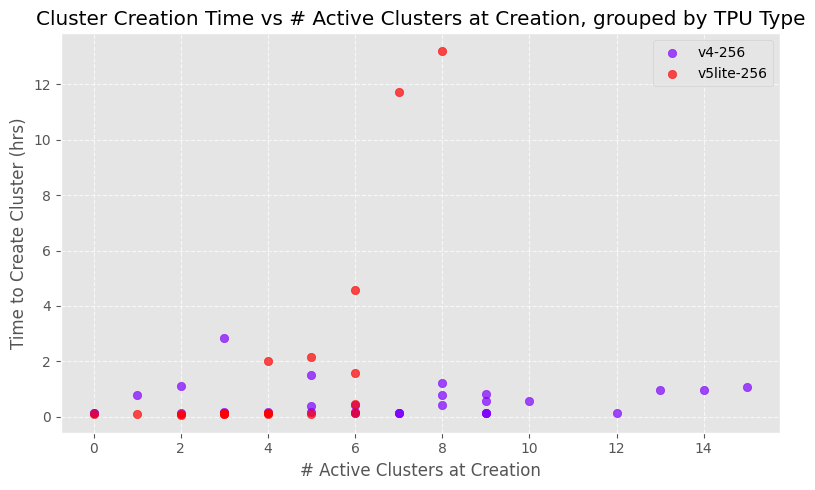

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot
plt.figure(figsize=(8, 5))

# Plot each TPU type with a different color
for tpu_type, color in zip(tpu_types, colors):
    mask = df['tpu_type'] == tpu_type
    plt.scatter(df.loc[mask, 'clusters_at_create'], 
                df.loc[mask, 'time_to_create_cluster'],
                c=[color], 
                label=tpu_type,
                alpha=0.7)

# Set labels and title
plt.xlabel('# Active Clusters at Creation')
plt.ylabel('Time to Create Cluster (hrs)')
plt.title('Cluster Creation Time vs # Active Clusters at Creation, grouped by TPU Type')

# Add legend
plt.legend()

# Show grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [22]:
df["effective_training"] = df["runtime"] / df["total_job_time"]

def get_time_to_1t(row):
    seq_len = 4096
    target = 1000000000000.0
    train_batch_size = row["train_batch_size"]
    global_step = row["global_step"]
    total_job_time = row["total_job_time"]
    total_steps = target / seq_len / train_batch_size
    time_to_train = total_steps / global_step * total_job_time
    return time_to_train


df["time_to_train_1T"] = df.apply(get_time_to_1t, axis=1)

# filter out jobs whose training_time is less than 1 hr
df_filtered = df[df["training_time"] > 1]
len(df), len(df_filtered)

(71, 66)

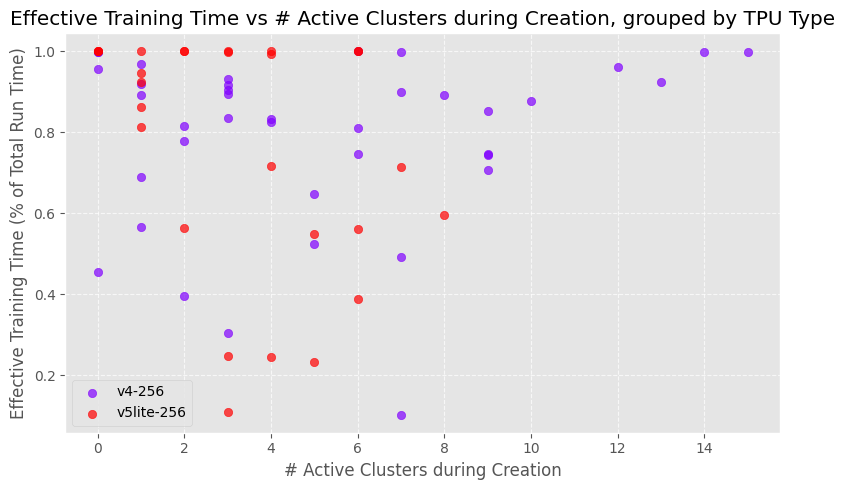

In [23]:
# Create a scatter plot
plt.figure(figsize=(8, 5))

# Plot each TPU type with a different color
for tpu_type, color in zip(tpu_types, colors):
    mask = df_filtered['tpu_type'] == tpu_type
    plt.scatter(df_filtered.loc[mask, 'clusters_at_create'], 
                df_filtered.loc[mask, 'effective_training'],
                c=[color], 
                label=tpu_type,
                alpha=0.7)

# Set labels and title
plt.xlabel('# Active Clusters during Creation')
plt.ylabel('Effective Training Time (% of Total Run Time)')
plt.title('Effective Training Time vs # Active Clusters during Creation, grouped by TPU Type')

# Add legend
plt.legend()

# Show grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


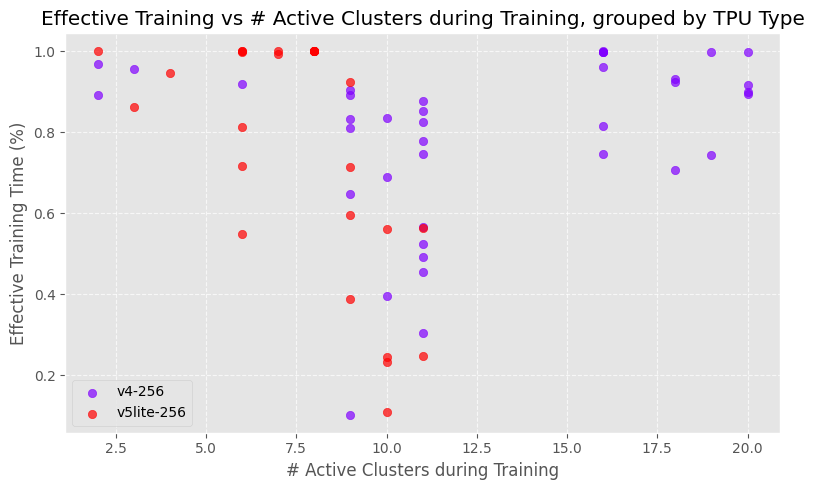

In [24]:
# Create a scatter plot
plt.figure(figsize=(8, 5))

# Plot each TPU type with a different color
for tpu_type, color in zip(tpu_types, colors):
    mask = df_filtered['tpu_type'] == tpu_type
    plt.scatter(df_filtered.loc[mask, 'clusters_at_running'], 
                df_filtered.loc[mask, 'effective_training'],
                c=[color], 
                label=tpu_type,
                alpha=0.7)

# Set labels and title
plt.xlabel('# Active Clusters during Training')
plt.ylabel('Effective Training Time (%)')
plt.title('Effective Training vs # Active Clusters during Training, grouped by TPU Type')

# Add legend
plt.legend()

# Show grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


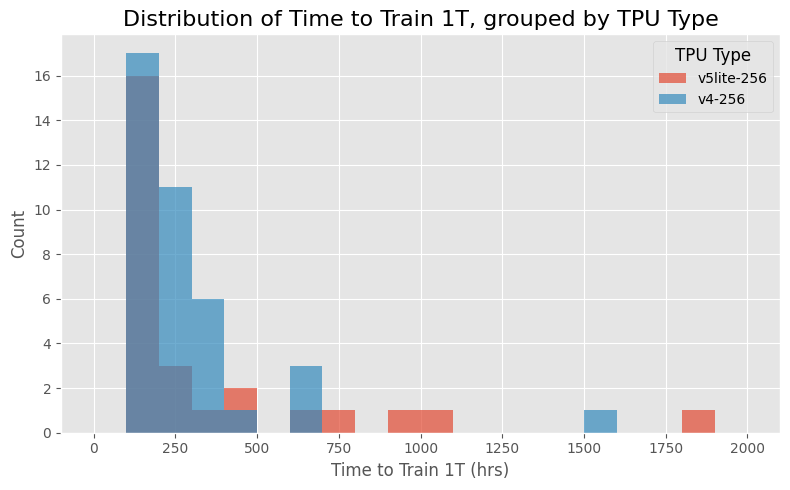

In [17]:
# Assuming you have your data in a DataFrame called 'df'
# If not, you'll need to load your data first
# df = pd.read_csv('your_data.csv')

# Set the style for better-looking plots
plt.style.use('ggplot')

# Get unique TPU types
tpu_types = df_filtered['tpu_type'].unique()

# Create the histogram
plt.figure(figsize=(8, 5))

for tpu_type in tpu_types:
    subset = df_filtered[df_filtered['tpu_type'] == tpu_type]
    plt.hist(subset['time_to_train_1T'], bins=20, range=(0, 2000), alpha=0.7, label=tpu_type)

# Customize the plot
plt.title('Distribution of Time to Train 1T, grouped by TPU Type', fontsize=16)
plt.xlabel('Time to Train 1T (hrs)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add a legend
plt.legend(title='TPU Type', title_fontsize='12', fontsize='10')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [14]:
df.to_csv("wandb_runs_with_launch_ts.csv", index=False)